In [1]:
import pandas as pd
import numpy as np
from numpy import nan
from main_util_func import *
import stellargraph as sg
from stellargraph import IndexedArray
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from sklearn import model_selection
#from IPython.display import display, HTML
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [2]:
%config Completer.use_jedi = False #autocomplete

In [3]:
def input_read():
    data_loc = './inter_files/input-output-data1.csv'
    data = pd.read_csv(data_loc, sep=',', lineterminator="\n", low_memory=False)
    data['input_nodes_sequence'] = data['input_nodes_sequence'].apply(lambda x : eval(x))
    data['output_seq'] = data['output_seq'].apply(lambda x : eval(x))
    data['output'] = data['output_seq'].apply(lambda x : x[-1])
    data['first_year']= data['input_years_sequence'].apply(lambda x:eval(x)[1]) #new
    data['flag'] = data['first_year']+15 <= 2021 #new
    data = data[data['flag']==True].copy() #new
    node_seq_len = [len(a) for a in data['input_nodes_sequence'].values]
    max_len = max(node_seq_len)
    return data, max_len

In [4]:
def graphs_data(embeddings, data):
    graph_labels= []
    graphs= []
    for head, family, family_edge, output in data[["Id","input_nodes_sequence","input_edgelist","output_seq"]].values:
        node_feat=[]
        source = []
        target = []
        if type(family)==str:
            family=eval(family)
        family_edge = eval(family_edge)
        for a in family:
            node_feat.append(embeddings[a])
        node_feat = np.array(node_feat)
        node_feat_inx = IndexedArray(node_feat, index=family)
        for edge in family_edge:
            source.append(edge[0])
            target.append(edge[1])
        family_edges = pd.DataFrame({"source":source, "target": target})
        graph = sg.StellarDiGraph(node_feat_inx, family_edges)
        graphs.append(graph)
        graph_labels.append(output)
    return graphs, graph_labels

In [16]:
def get_model(generator):
    gc_model = sg.layer.GCNSupervisedGraphClassification(
        [64, 36], ["relu", "relu"], generator, pool_all_layers=True
    )
    inp1, out1 = gc_model.in_out_tensors()
    # inp2, out2 = gc_model.in_out_tensors()

    # vec_distance = tf.norm(out1 - out2, axis=1)
    predictions = Dense(units=32, activation="relu")(out1)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1)(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=inp1, outputs=predictions)
    model.compile(optimizer=Adam(0.001), loss=MeanSquaredError())
    embedding_model = keras.Model(inp1, out1)
    return model, embedding_model

In [ ]:
#print(model.summary())

In [ ]:
# def graph_distance(g1, g2):
#     #print(graph1.info())
#     #print(graph2.info())
#     spec1 = nx.directed_laplacian_matrix(nx.DiGraph(g1.to_networkx(feature_attr=None)), weight=None)
#     #print(spec1)
#     spec2 = nx.directed_laplacian_matrix(nx.DiGraph(g2.to_networkx(feature_attr=None)), weight=None, alpha=0.95)
#     #print(spec2)
#     r1,c1 = spec1.shape[0], spec1.shape[1]
#     r2,c2 = spec2.shape[0], spec2.shape[1]
#     r = max(spec1.shape[0], spec2.shape[0])
#     c = max(spec1.shape[1], spec2.shape[1])
#     spec11 = np.pad(spec1, [(0,r-r1), (0,c-c1)], constant_values=0)
#     spec21 = np.pad(spec2, [(0,r-r2), (0,c-c2)], constant_values=0)
#     #print(spec1)
#     #print(spec2)
#     #print(r,c)
#     dist = np.linalg.norm(spec11 - spec21)
#     if np.isnan(dist):
#         dist=4
#     return dist

In [6]:
def family_size(graph):
    return len(graph.nodes())

In [9]:
def train_model(graphs, model, embed):
    targets = np.array([family_size(g) for g in graphs])
    graph_idx = np.random.RandomState(0).randint(len(graphs), size=(10000))
    train_gen = generator.flow(graph_idx, batch_size=10, targets=targets[graph_idx])
    history = model.fit(train_gen, epochs=10, verbose=1)
    embeddings = embedding_model.predict(generator.flow(graphs))
    return embeddings, history

In [ ]:
if __name__=="__main__":
    data, max_len = input_read()
    data = data.iloc[0:100]
    secibert_embeddings  = load_obj('combined_reduced_tsne_embed')
    graphs, graph_labels = graphs_data(secibert_embeddings, data)
    generator = PaddedGraphGenerator(graphs=graphs)
    model, embedding_model = get_model(generator)
    new_embeddings, history = train_model(graphs, model, embedding_model)
    sg.utils.plot_history(history)

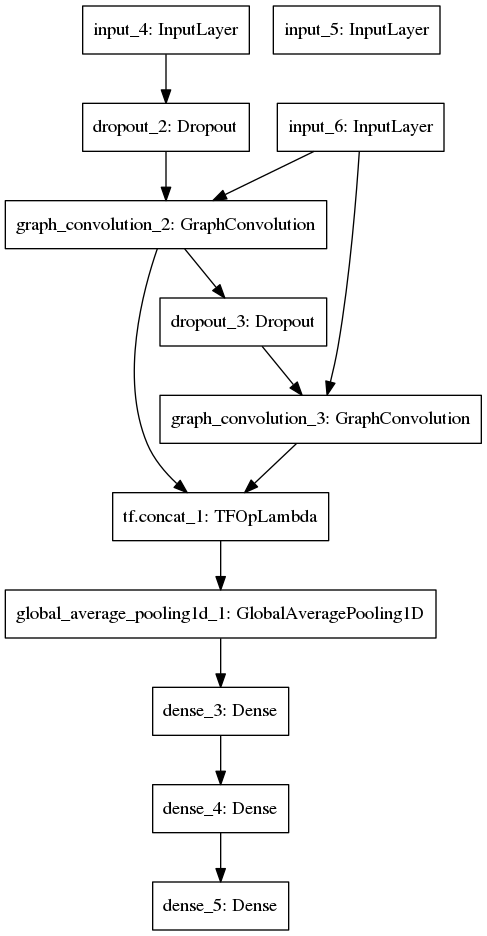

In [11]:
plot_model(model)

In [ ]:
#graph_distance(graphs[30403], graphs[21243])

In [ ]:
#graph_idx

In [ ]:
#print(graphs[42613].info())

In [ ]:
#graph_idx

In [ ]:
#targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]

In [ ]:
#targets

In [ ]:
#nx.directed_laplacian_matrix(nx.DiGraph(graphs[0].to_networkx(feature_attr=None)))

In [ ]:
# for i in train_gen:
#     print(i)

In [ ]:
#es = EarlyStopping(monitor="loss", min_delta=0, patience=25, restore_best_weights=True)

In [ ]:
#pair_model.compile(optimizer=Adam(0.001), loss="mse")

In [ ]:
#%%time

In [ ]:
#history.history